# YOLO Pretraining with IMAGENET-VID

## Imports

In [ ]:
%pip install huggingface_hub ultralytics torchinfo pygwalker comet_ml

In [9]:
import os
import shutil
from os import path

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, utils, transforms
from torchinfo import summary
from ultralytics import YOLO

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pygwalker as pyg

import comet_ml

In [10]:
# Attatch logger to the current project
comet_ml.login(project_name="APT")

### Check GPU Availability

In [11]:
!nvidia-smi

Thu Feb 27 20:13:56 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |   7320MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [12]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 3
ADDITIONAL_GPU = 1

if torch.cuda.is_available():
    if ADDITIONAL_GPU:
        torch.cuda.set_device(DEVICE_NUM)
        device = torch.device("cuda")
    else:
        device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}" + (f":{DEVICE_NUM}" if ADDITIONAL_GPU else ""))

INFO: Using device - cuda:3


In [13]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

INFO: Number of CPU cores - 48


## Define Dataset
ImageNet-VID

In [113]:
from typing import Callable, Optional
from dataclasses import dataclass
from pathlib import Path
import huggingface_hub
import json
import sys


@dataclass
class DataPair:
    train: any
    val: any


class ImageNetVIDDataset(datasets.ImageFolder):
    """
    ImageNet-VID dataset for Object Detection and Tracking.
    Only works in Linux.
    
    :ref: https://huggingface.co/datasets/guanxiongsun/imagenetvid
    """

    download_method = huggingface_hub.snapshot_download
    dataset_name = "ILSVRC2015_VID"
    dataset_id = "guanxiongsun/imagenetvid"
    obj_classes = [
        "airplane", "antelope", "bear", "bicycle", "bird", "bus", "car", "cattle",
        "dog", "domestic cat", "elephant", "fox", "giant panda", "hamster", "horse",
        "lion", "lizard", "monkey", "motorcycle", "rabbit", "red panda",
        "sheep", "snake", "squirrel", "tiger", "train", "turtle",
        "watercraft", "whale", "zebra"
    ]
    __cached_annotation = DataPair(None, None)
    annotation_files = DataPair("imagenet_vid_train.json", "imagenet_vid_val.json")

    def __init__(
        self,
        root: str,
        force_download: bool = True,
        train: bool = True,
        valid: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
        ):
        self.root = path.join(root, self.dataset_name)
        self.download(self.root, force=force_download)

        if train:
            self.root = path.join(self.root, "val") if valid else path.join(self.root, "train")
        else:
            self.root = path.join(self.root, "test")

        super().__init__(root=self.root, transform=transform, target_transform=target_transform)

    def apply_transform(
        self, transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
        ):
        self.transform = self.transforms = transform  # For back-ward compatibility
        self.transforms = self.target_transform = target_transform

    @classmethod
    def download(cls, root: str, force: bool = False):
        root = Path(root)
        
        # Clean up the existing dataset if force is flagged
        if force:
            print(f"INFO: Cleaning up the existing dataset at {root} (Force-download is flagged)")
            for item in os.listdir(root):
                item_path = root / item
                if path.isfile(item_path):
                    os.remove(item_path)
                else:
                    shutil.rmtree(item_path)
            print("INFO: Dataset cleaned successfully.")

        # Do download if the dataset does not exist
        print(f"INFO: Downloading '{cls.dataset_id} from huggingface to {root}...")
        dnlod = lambda: cls.download_method(
            repo_id=cls.dataset_id,
            repo_type="dataset",
            local_dir=root,
            ignore_patterns=["*.git*", "*.md", "*ILSVRC2017*"]
        )
        if force or not (
            path.exists(root) and any(p for p in Path(root).iterdir() if not p.name.startswith('.'))
        ):  # Check if dataset files already exist in the directory
            dnlod()
            print("INFO: Dataset downloaded successfully.")
        else:
            dnlod()  # make sure the dataset is up-to-date
            print("INFO: Dataset files found in the root directory. Skipping download.")
        
        # Combine split achives
        dataset_archive, annotation_archive = root / f"{cls.dataset_name}.tar.gz", root / "annotations.tar.gz"
        if not path.exists(dataset_archive):
            print("INFO: Combining seperated archives...")
            result = os.system(f"cat {dataset_archive}.a* | dd status=progress of={dataset_archive}")
            #result = os.system(f"cat {dataset_archive}.a* | pv -s $(du -bc {dataset_archive}.a* | tail -1 | cut -f1) > {dataset_archive}")
            if result != 0:
                raise Exception("Failed to combine split archives. Please make sure that you are running on a Linux system.")
            print("INFO: Split archives combined successfully.")
        else:
            print("INFO: Combined archives found in the root directory. Skipping combination.")

        # Extract the dataset
        if path.isfile(root / "train" / cls.annotation_files.train) and path.isfile(root / "val" / cls.annotation_files.val):
            print("INFO: Dataset is already extracted")
        else:
            print("INFO: Extracting the dataset...", flush=True)
            if os.system(f"dd if={dataset_archive} bs=4M status=progress | tar -I pigz -x -C {root}") \
                or os.system(f"dd if={annotation_archive} bs=4M status=progress | tar -I pigz -x -C {root}") \
            :
                #os.system(f"pv {dataset_archive} | tar -I pigz -x -C {root}")
                print("\nERROR: Cannot find pigz in the system, using default tar command instead", file=sys.stderr, flush=True)
                if os.system(f"dd if={dataset_archive} bs=4M status=progress | tar -x -C {root}") \
                    or os.system(f"dd if={annotation_archive} bs=4M status=progress | tar -x -C {root}") \
                :
                    #os.system(f"pv {dataset_archive} | tar -x -C {root}")
                    raise Exception(f"Failed to extract {dataset_archive}")
            # ----
            # Move files to the correct directories
            temp_dir = root / cls.dataset_name.replace("_VID", "")
            # ---- metadata
            #os.system(f"mv {temp_dir}/ImageSets/VID/* {root}")
            # ---- datas
            for subdir in os.listdir(f"{temp_dir}/Data/VID/train"):  # flatten the train data directory
                annt = temp_dir / "Annotations" / "VID" / "train"
                dt = temp_dir / "Data" / "VID" / "train"
                os.system(f"mv {annt}/{subdir}/* {annt}/")
                os.system(f"mv {dt}/{subdir}/* {dt}/")
                os.system(f"rmdir {annt}/{subdir}")
                os.system(f"rmdir {dt}/{subdir}")
            os.system(f"mv {temp_dir}/Data/VID/* {root}")  # copy images
            for data_type in ["train", "val"]:
                for subdir in os.listdir(f"{root}/{data_type}"):  # copy lables
                    os.system(f"mv {temp_dir}/Annotations/VID/{data_type}/{subdir}/* {root}/{data_type}/{subdir}")
            os.system(f"rm -r {temp_dir}")
            # ---- json files
            os.system(f"mv {root}/annotations/{cls.annotation_files.train} {root}/train/{cls.annotation_files.train}")
            os.system(f"mv {root}/annotations/{cls.annotation_files.val} {root}/val/{cls.annotation_files.val}")
            os.system(f"rm -r {root}/annotations/")

            print("INFO: Dataset is extracted successfully")

    @classmethod
    def bbox(cls, img_index: int, root: str, train: bool = True, normalize: bool = False):
        root = Path(root) / cls.dataset_name

        if train and cls.__cached_annotation.train is None:
            with open(root / "train" / cls.annotation_files.train, "r", encoding="utf-8") as f:
                cls.__cached_annotation.train = json.load(f)
        if not train and cls.__cached_annotation.val is None:
            with open(root / "val" / cls.annotation_files.val, "r", encoding="utf-8") as f:
                cls.__cached_annotation.val = json.load(f)

        cache = cls.__cached_annotation.train if train else cls.__cached_annotation.val
        bbox_info = cache['annotations'][img_index]['bbox']
        if normalize:
            image_id = cache['annotations'][img_index]['image_id'] - 1
            height, width = cache['images'][image_id]['height'], cache['images'][image_id]['width']
            bbox_info = [
                bbox_info[0] / width, bbox_info[1] / height,
                bbox_info[2] / width, bbox_info[3] / height
            ]
        return torch.Tensor(bbox_info)

    @property
    def df(self) -> pd.DataFrame:
        return pd.DataFrame(dict(path=[d[0] for d in self.samples], label=[self.classes[lb] for lb in self.targets]))

    def output_sampling(self, img_norm: dict, idx: int | None = None, figsize=(7, 5), imgsize=(224, 224)):
        # Get random index if not provided
        if idx is None:
            idx = np.random.randint(len(self))
            if idx == 0:
                idx = 1
        
        # Get frame pair
        (prev_img, prev_gt), (curr_img, curr_gt) = self[idx-1], self[idx]
        
        # Convert tensors to numpy arrays and denormalize
        def denormalize(img_tensor):
            # Move channels to last dimension
            img = img_tensor.permute(1, 2, 0).numpy()
            # Denormalize
            img = img * np.array(img_norm['std']) + np.array(img_norm['mean'])
            # Clip values to valid range
            img = np.clip(img, 0, 1)
            return img
        
        prev_img = denormalize(prev_img)
        curr_img = denormalize(curr_img)
        
        def draw_bbox(ax, bbox, color='red'):
            """Helper function to draw bounding box"""
            x, y, w, h = bbox.numpy()
            x *= imgsize[0]
            y *= imgsize[1]
            w *= imgsize[0]
            h *= imgsize[1]
            ax.plot([x, x+w], [y, y], color=color, linewidth=2)
            ax.plot([x, x], [y, y+h], color=color, linewidth=2)
            ax.plot([x+w, x+w], [y, y+h], color=color, linewidth=2)
            ax.plot([x, x+w], [y+h, y+h], color=color, linewidth=2)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot previous frame
        ax1.imshow(prev_img)
        #draw_bbox(ax1, prev_gt)
        ax1.set_title('Previous Frame')
        ax1.axis('off')
        
        # Plot current frame
        ax2.imshow(curr_img)
        #draw_bbox(ax2, curr_gt)
        ax2.set_title('Current Frame')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return idx

In [114]:
# Define image size for resizing
IMG_SIZE = 640

# Define image normalization parameters (ImageNet style)
IMG_NORM = dict(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Create transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(**IMG_NORM)
])
label_transform = lambda root, train, norm: transforms.Lambda(
    lambda x: ImageNetVIDDataset.bbox(x, root=root, train=train, normalize=norm)
)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), 
    transforms.Normalize(**IMG_NORM)
])

In [115]:
DATA_ROOT = path.join(".", "data")

train_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, train=True,
    transform=train_transform, target_transform=label_transform(root=DATA_ROOT, train=True, norm=True)
)
valid_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, valid=True,
    transform=train_transform, target_transform=label_transform(root=DATA_ROOT, train=False, norm=True)
)
test_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, train=False,
    transform=test_transform
)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Dataset loaded successfully. Number of samples - Train(1122397), Valid(176126), Test(315176)


In [116]:
# Train Dataset Distribution
pyg.walk(train_dataset.df)

Box(children=(HTML(value='\n<div id="ifr-pyg-00062f29316058f7cv5zdM4fFCwV6QGT" style="height: auto">\n    <hea…

In [117]:
train_dataset[0]

(tensor([[[-0.8507, -0.8335, -0.7822,  ...,  0.9988,  0.9988,  0.9988],
          [-0.7822, -0.7479, -0.7137,  ...,  1.0331,  1.0331,  1.0331],
          [-0.8335, -0.7479, -0.6281,  ...,  1.0673,  1.0673,  1.0673],
          ...,
          [ 0.1768,  0.3138,  0.4851,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.1768,  0.3138,  0.4851,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.1768,  0.3138,  0.4851,  ...,  2.2489,  2.2489,  2.2489]],
 
         [[-0.6527, -0.6352, -0.6176,  ...,  1.4307,  1.4307,  1.4307],
          [-0.6176, -0.5826, -0.5126,  ...,  1.4657,  1.4657,  1.4657],
          [-0.6352, -0.5826, -0.4601,  ...,  1.4832,  1.4832,  1.4832],
          ...,
          [ 0.9055,  1.0455,  1.1155,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.9055,  1.0455,  1.1155,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.9055,  1.0455,  1.1155,  ...,  2.4286,  2.4286,  2.4286]],
 
         [[-0.3404, -0.2881, -0.2707,  ...,  1.1411,  1.1411,  1.1411],
          [-0.2707, -0.2358,

In [118]:
train_dataset._ImageNetVIDDataset__cached_annotation.train.keys()

dict_keys(['categories', 'videos', 'images', 'annotations'])

In [119]:
train_dataset._ImageNetVIDDataset__cached_annotation.train['annotations'][0]

{'id': 1,
 'video_id': 1,
 'image_id': 1,
 'category_id': 17,
 'instance_id': 1,
 'bbox': [323, 216, 727, 212],
 'area': 154124,
 'iscrowd': False,
 'occluded': True,
 'generated': False}

In [120]:
train_dataset._ImageNetVIDDataset__cached_annotation.train['images'][0]

{'file_name': 'train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00000000/000000.JPEG',
 'height': 720,
 'width': 1280,
 'id': 1,
 'frame_id': 0,
 'video_id': 1,
 'is_vid_train_frame': False}

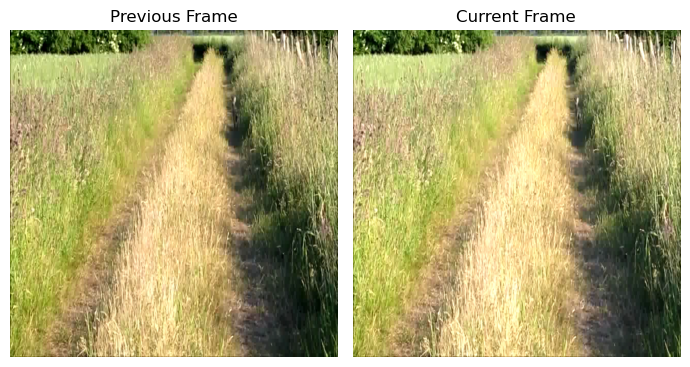

Visualized pair index: 231941


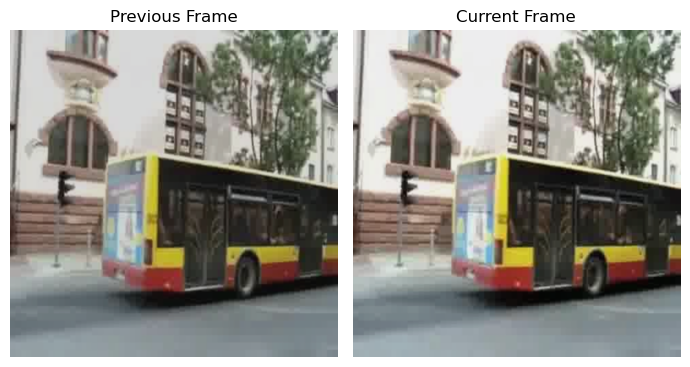

Visualized pair index: 524663


In [121]:
for _ in range(2):
    selected_idx = train_dataset.output_sampling(img_norm=IMG_NORM, imgsize=(IMG_SIZE, IMG_SIZE))
    print(f"Visualized pair index: {selected_idx}")

## Load Model

In [85]:
model = YOLO("yolo11m.yaml")  # build a new model from YAML
#model = YOLO("path/to/last.pt")  # load a partially trained model
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [ ]:
train_configs = dict(
    data="imagenetvid.yaml",
    epochs=100,
    patience=10,
    batch=512,
    imgsz=640,
    save=True,
    save_period=10,
    cache=True,
    device=list(range(DEVICE_NUM, DEVICE_NUM+ADDITIONAL_GPU+1)) if ADDITIONAL_GPU else DEVICE_NUM,
    workers=cpu_cores,
    project="pretrained4imagenetvid",
    resume=True,
    val=True,
    plots=True
)

## Train

In [ ]:
# Start/Resume model training
results = model.train(**train_configs)

## Validation

In [ ]:
# Evaluate model performance on the validation set
metrics = model.val()

In [ ]:
# Perform object detection on an image
results = model("./data/ILSVRC2015_VID/val/.jpg")
results[0].show()